In [209]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import io
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
import lightgbm as lgb
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, plot_confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import classification_report, f1_score
from itertools import cycle
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore");

# Description

Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets: 

- 1 school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira) 
- 2 sex - student's sex (binary: 'F' - female or 'M' - male) 
- 3 age - student's age (numeric: from 15 to 22) 
- 4 address - student's home address type (binary: 'U' - urban or 'R' - rural) 
- 5 famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
- 6 Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart) 
- 7 Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education) 
- 8 Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education) 
- 9 Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
- 10 Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 
- 11 reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other') 
- 12 guardian - student's guardian (nominal: 'mother', 'father' or 'other') 
- 13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour) 
- 14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) 
- 15 failures - number of past class failures (numeric: n if 1<=n<3, else 4) 
- 16 schoolsup - extra educational support (binary: yes or no) 
- 17 famsup - family educational support (binary: yes or no) 
- 18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no) 
- 19 activities - extra-curricular activities (binary: yes or no) 
- 20 nursery - attended nursery school (binary: yes or no) 
- 21 higher - wants to take higher education (binary: yes or no) 
- 22 internet - Internet access at home (binary: yes or no) 
- 23 romantic - with a romantic relationship (binary: yes or no) 
- 24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent) 
- 25 freetime - free time after school (numeric: from 1 - very low to 5 - very high) 
- 26 goout - going out with friends (numeric: from 1 - very low to 5 - very high) 
- 27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high) 
- 28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high) 
- 29 health - current health status (numeric: from 1 - very bad to 5 - very good) 
- 30 absences - number of school absences (numeric: from 0 to 93) 

These grades are related with the course subject, Math or Portuguese: 

- 31 G1 - first period grade (numeric: from 0 to 20) 
- 31 G2 - second period grade (numeric: from 0 to 20) 
- 32 G3 - final grade (numeric: from 0 to 20, output target)

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. 

# Preparation

### Load dataset

In [3]:
# Mathematics
df_m = pd.read_csv("student-mat.csv", sep=';')

# Portuguese
df_p = pd.read_csv("student-por.csv", sep=';')

In [4]:
df_m['subject'] = 'math'
df_p['subject'] = 'port'

In [5]:
df = df_m.append(df_p)

In [6]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,math
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,math
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,math
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,math
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,math


### Academic grading in Portugal

https://en.wikipedia.org/wiki/Academic_grading_in_Portugal

In [7]:
df['G3_qualif'] = ''
df.loc[(df.G3 >= 0) & (df.G3 <= 4), 'G3_qualif'] = 'poor' 
df.loc[(df.G3 > 4) & (df.G3 <= 10), 'G3_qualif'] = 'weak' 
df.loc[(df.G3 > 10) & (df.G3 <= 14), 'G3_qualif'] = 'sufficient' 
df.loc[(df.G3 > 14) & (df.G3 <= 16), 'G3_qualif'] = 'good' 
df.loc[(df.G3 > 16) & (df.G3 <= 20), 'G3_qualif'] = 'very good/excellent' 
df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,Dalc,Walc,health,absences,G1,G2,G3,subject,G3_qualif
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,6,5,6,6,math,weak
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,1,1,3,4,5,5,6,math,weak
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,2,3,3,10,7,8,10,math,weak
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,1,1,5,2,15,14,15,math,good
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,1,2,5,4,6,10,10,math,weak


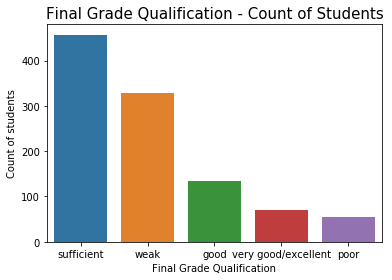

In [8]:
sns.countplot(data=df, x='G3_qualif', order=df.G3_qualif.value_counts().index)
plt.title('Final Grade Qualification - Count of Students',fontsize=15)
plt.xlabel('Final Grade Qualification'); plt.ylabel('Count of students');

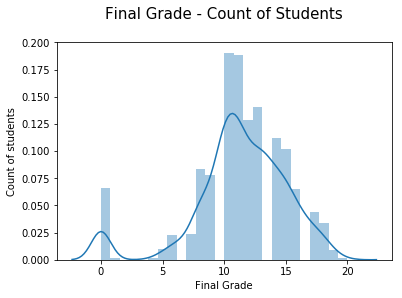

In [9]:
sns.distplot(df['G3'])
plt.title('Final Grade - Count of Students\n',fontsize=15)
plt.xlabel('Final Grade'); plt.ylabel('Count of students');

Descriptive statistics is a helpful way to understand characteristics of your data and to get a quick summary of it. The describe function applies basic statistical computations: extreme values, count of data points standard deviation etc, excluding NaN values.

In [10]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


Checking feature information

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 648
Data columns (total 35 columns):
school        1044 non-null object
sex           1044 non-null object
age           1044 non-null int64
address       1044 non-null object
famsize       1044 non-null object
Pstatus       1044 non-null object
Medu          1044 non-null int64
Fedu          1044 non-null int64
Mjob          1044 non-null object
Fjob          1044 non-null object
reason        1044 non-null object
guardian      1044 non-null object
traveltime    1044 non-null int64
studytime     1044 non-null int64
failures      1044 non-null int64
schoolsup     1044 non-null object
famsup        1044 non-null object
paid          1044 non-null object
activities    1044 non-null object
nursery       1044 non-null object
higher        1044 non-null object
internet      1044 non-null object
romantic      1044 non-null object
famrel        1044 non-null int64
freetime      1044 non-null int64
goout         1044 non-null

Checking missing values

In [12]:
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
subject       0
G3_qualif     0
dtype: int64

# Exploratory data analysis

### Heatmap of correlations

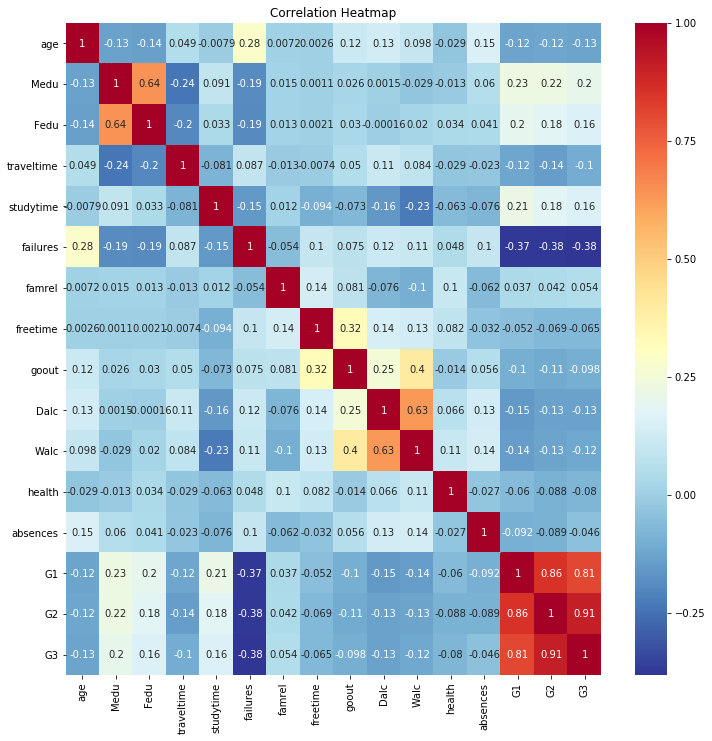

In [13]:
corr = df.corr()
plt.figure(figsize = (12, 12))

sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, annot = True)
plt.title('Correlation Heatmap');

The target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

Look at the number of students in Math and Portuguese in object attributes

In [14]:
obj_col = list(df.select_dtypes('object').columns)
obj_col.remove('subject')

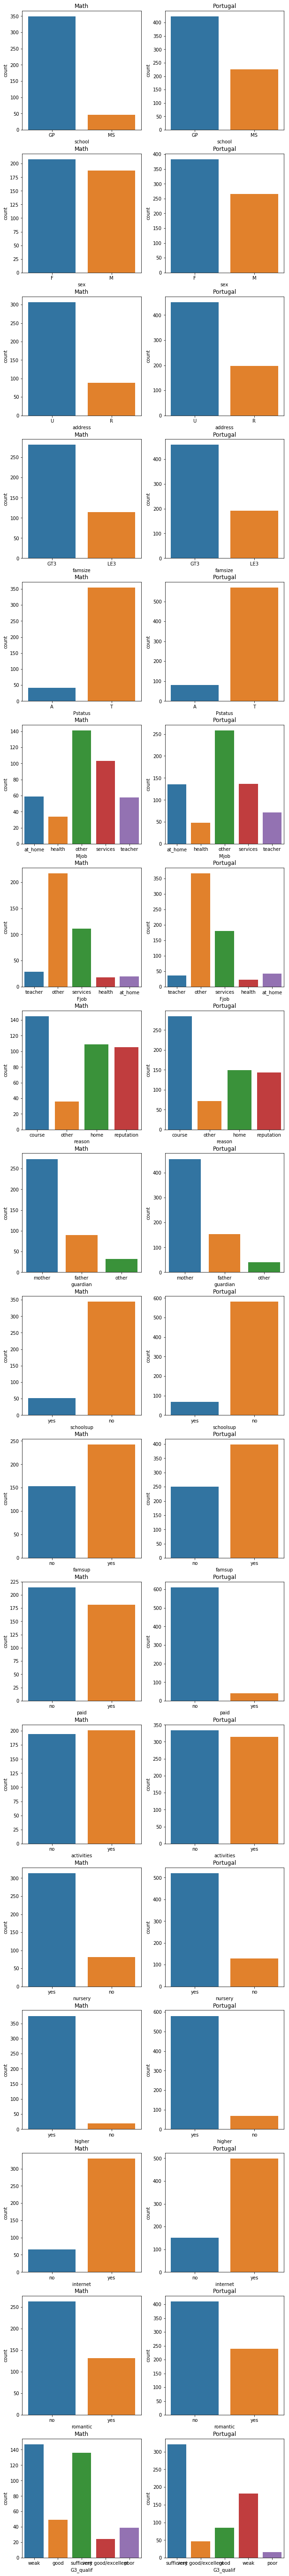

In [77]:
fig,ax = plt.subplots(len(obj_col),2, figsize=(10,100))

for i, col in enumerate(obj_col):
    p1 = sns.countplot(x=col, data=df[df.subject == 'math'], ax=ax[i,0]).set_title('Math')
    p2 = sns.countplot(x=col, data=df[df.subject == 'port'], ax=ax[i,1]).set_title('Portugal')

Most students take a math course at the Gabriel Pereira school. Students also take more extra paid classes within the Math course.

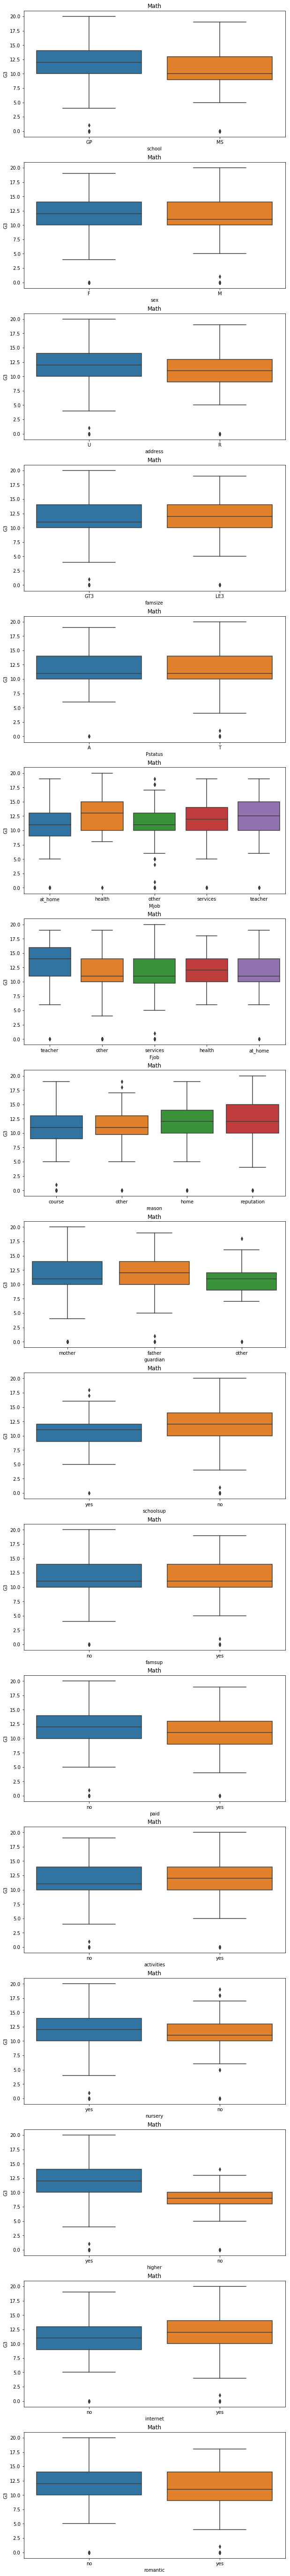

In [78]:
fig,ax = plt.subplots(len(obj_col[:-1]),1, figsize=(10,100))

for i, col in enumerate(obj_col[:-1]):
    p1 = sns.boxplot(x=col, y = 'G3', data=df, ax=ax[i]).set_title('Math')

The average score may be higher if a student studies at the Gabriel Pereira school, lives in the city, if his parents are teacher, the reason to choose this school is reputation, he doesn't have additional paid classes within the subject course, wants to get a higher education and has access to the Internet at home.

Look at the number of students in Math and Portuguese in numeric attributes

In [22]:
num_col = list(df.select_dtypes('int').columns)[:-1]

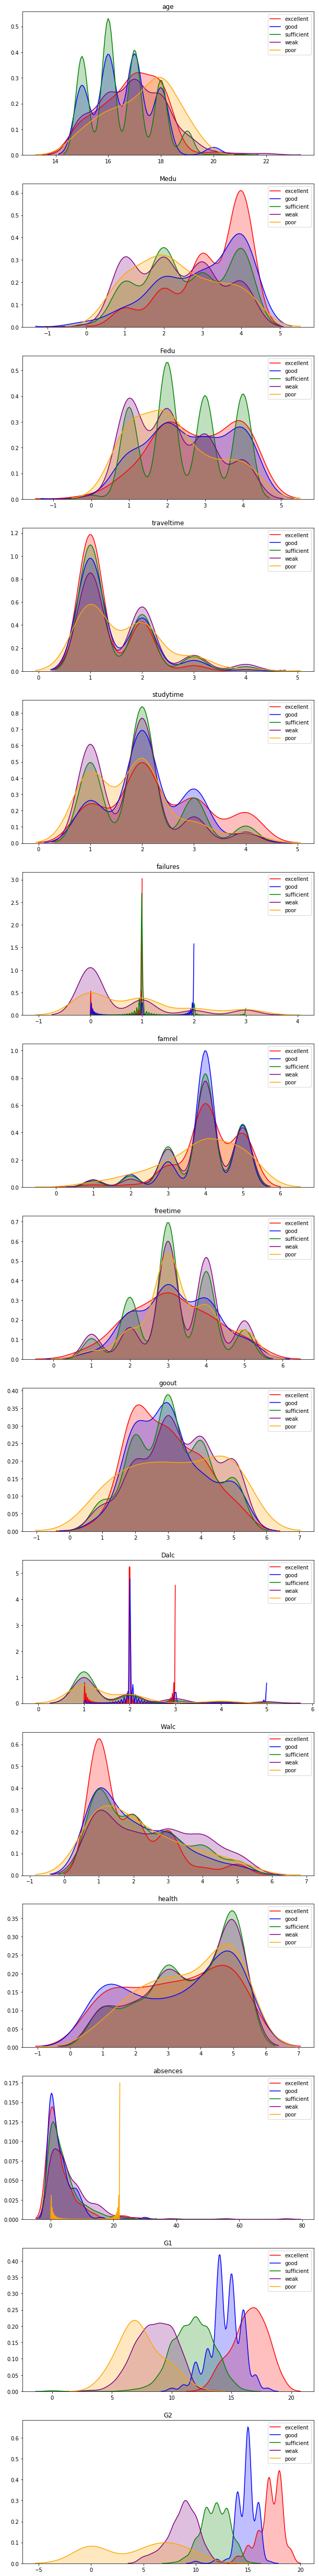

In [92]:
good = df[df.G3_qualif == 'good']
poor = df[df.G3_qualif == 'poor']
sufficient = df[df.G3_qualif == 'sufficient']
excellent = df[df.G3_qualif == 'very good/excellent']
weak = df[df.G3_qualif == 'weak']

color = ['blue', 'orange', 'green', 'red', 'purple']
fig,ax = plt.subplots(len(num_col),1, figsize=(10,90))

for i, col in enumerate(num_col):
    good['good'] = good[col]
    poor['poor'] = poor[col]
    sufficient['sufficient'] = sufficient[col]
    excellent['excellent'] = excellent[col]
    weak['weak'] = weak[col]
    
    p1=sns.kdeplot(excellent['excellent'], shade=True, color=color[3], ax=ax[i]).set_title(col)
    p1=sns.kdeplot(good['good'], shade=True, color=color[0], ax=ax[i]).set_title(col)
    p1=sns.kdeplot(sufficient['sufficient'], shade=True, color=color[2], ax=ax[i]).set_title(col)
    p1=sns.kdeplot(weak['weak'], shade=True, color=color[4], ax=ax[i]).set_title(col)
    p1=sns.kdeplot(poor['poor'], shade=True, color=color[1], ax=ax[i]).set_title(col);

## Classification

In [365]:
def plot_multi_roc_curve(y_test, X_test, model, n_classes):
    lw = 2
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    pred = model.predict(X_test)
    y_test = np.array(pd.get_dummies(y_test))
    pred = np.array(pd.get_dummies(pred))
        
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    
    # Plot all ROC curves
    plt.figure(figsize=(5,5))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    colors = cycle(['blue', 'orange', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc["micro"]

### Prepare Dataset for Modelling

In [120]:
X = pd.get_dummies(df.drop(['G3', 'G3_qualif'], axis=1)).values
y = le.fit_transform(df['G3_qualif'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Logistic Regression

Find the best hyperameters for model

In [121]:
lr = LogisticRegression()
lr_params = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}

grid_search_lr = GridSearchCV(lr, param_grid = lr_params, cv = 10)
grid_search_lr.fit(X_train,y_train)
grid_search_lr.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [282]:
lr = LogisticRegression(penalty='l2', C=10,class_weight='balanced')

Fit model and use cross-validation to select best hyperameters

Steps in kfold cross validation:

- Split data set into k unique sets or folds
- Fit model on k-1 sets, predict and calculate model metric on set not used
- Do above process k times, each time leaving out and predicting on a different set

In [342]:
def train_kfold(X_train, y_train, model, y_test, X_test):
    kf = KFold(n_splits=10,shuffle=True)
    pred_test_full =0
    cv_score =[]
    i=1

    for train_index, test_index in kf.split(X_train, y_train):
        X_train_, X_test_ = X_train[train_index], X_train[test_index]
        y_train_, y_test_ = y_train[train_index], y_train[test_index]
        model.fit(X_train_,y_train_)
        score = f1_score(y_test_,model.predict(X_test_), average='micro')
        #print('F1 :',score)
        cv_score.append(score)    
        pred_test = lr.predict_proba(X_test)[:,1]
        pred_test_full +=pred_test
        i+=1
    print('   ')
    print('Mean cv Score',np.mean(cv_score))
   # print(pred_test_full)
    
    # Plot non-normalized confusion matrix
    disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=set(y_test),
                                     cmap=plt.cm.Blues,
                                     normalize='true')
    disp.ax_.set_title("Normalized confusion matrix")
    
    roc_auc_m = plot_multi_roc_curve(y_test, X_test, model, n_classes=5)
    return np.mean(cv_score), roc_auc_m

   
Mean cv Score 0.7023237997957098


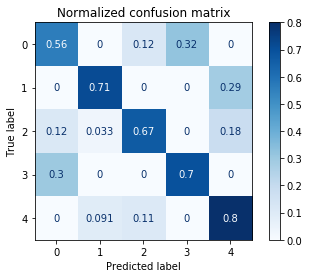

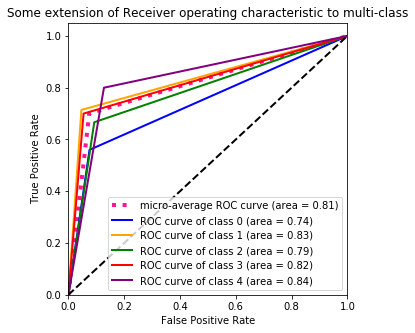

In [344]:
cv_lr, roc_auc_m_lr = train_kfold(X_train, y_train, lr, y_test, X_test)

## Decision Tree Classification

In [218]:
dt = DecisionTreeClassifier()

dt_params = {'criterion': ['gini', 'entropy'],
            'max_depth': [2,3,4,6,8,12]}

grid_search_dt = GridSearchCV(dt, param_grid = dt_params, cv = 10)
grid_search_dt.fit(X_train,y_train)
grid_search_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [285]:
dt = DecisionTreeClassifier(max_depth=4, criterion='entropy' ,class_weight='balanced')

   
Mean cv Score 0.7721271705822267


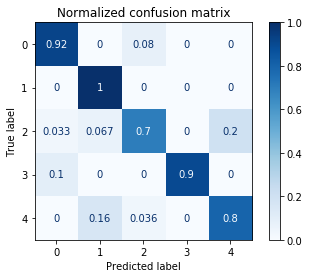

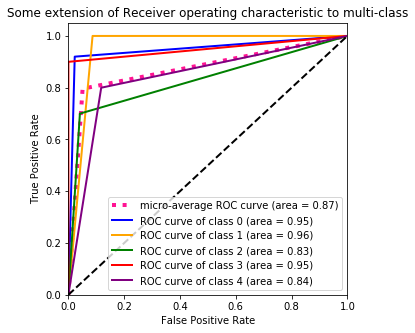

In [345]:
cv_dt, roc_auc_m_dt = train_kfold(X_train, y_train, dt, y_test, X_test)

## Random Forest Classifier

In [264]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf_params = {'n_estimators': [200, 300],
            'max_features': ['auto', 'sqrt'],
            'max_depth' : [2,3,4,6,8,12],
            'criterion' :['gini', 'entropy']}

grid_search_rf = GridSearchCV(rf, param_grid = rf_params, cv = 10)
grid_search_rf.fit(X_train,y_train)
grid_search_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [347]:
rf = RandomForestClassifier(n_estimators=200, max_depth=12, criterion='entropy', \
                            max_features='sqrt', class_weight='balanced')

   
Mean cv Score 0.7846016343207355


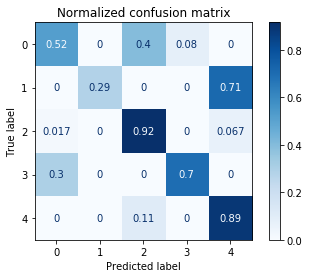

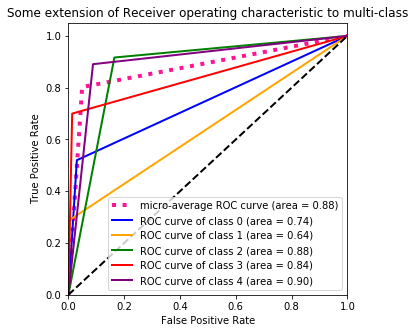

In [348]:
cv_rf, roc_auc_m_rf = train_kfold(X_train, y_train, rf, y_test, X_test)

## XGBClassifier

In [290]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb_params = {'gamma' :  [0.5, 1, 1.5, 2, 5],
            'max_depth' : [2,3,4,6,8,12]}

grid_search_xgb = GridSearchCV(xgb, param_grid = xgb_params, cv = 10)
grid_search_xgb.fit(X_train,y_train)
grid_search_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.5,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [307]:
xgb = XGBClassifier(gamma=1.5, class_weight='balanced')

   
Mean cv Score 0.8332226762002042


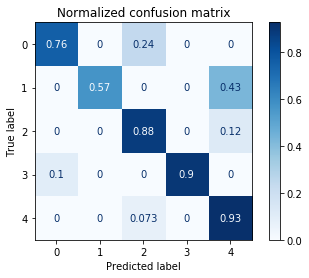

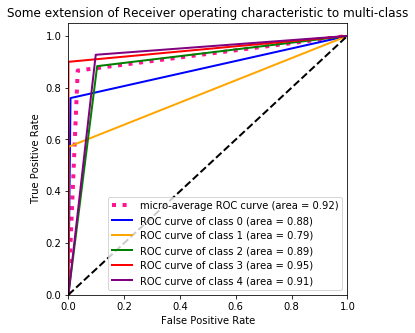

In [349]:
cv_xgb, roc_auc_m_xgb = train_kfold(X_train, y_train, xgb, y_test, X_test)

## LGBMClassifier

In [299]:
import lightgbm as lgb

lgb_ = lgb.LGBMClassifier()

lgb_params = {'n_estimators' :  [100, 200],
              'learning_rate': [0.001, 0.05, 0.1],
            'max_depth' : [2,3,4,6,8,12]}

grid_search_lgb = GridSearchCV(lgb_, param_grid = lgb_params, cv = 10)
grid_search_lgb.fit(X_train,y_train)
grid_search_lgb.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [305]:
import lightgbm as lgb
lgb_ = lgb.LGBMClassifier(class_weight='balanced')

   
Mean cv Score 0.8014811031664963


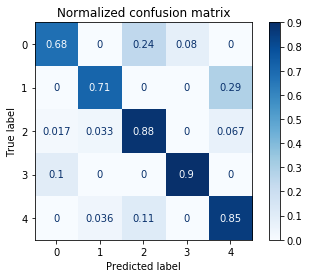

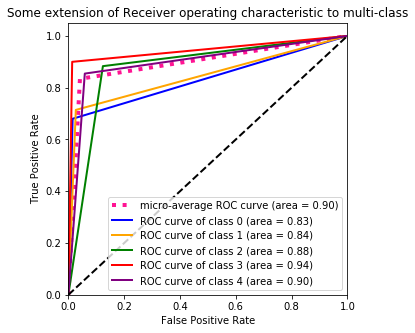

In [350]:
cv_lgb, roc_auc_m_lgb = train_kfold(X_train, y_train, lgb_, y_test, X_test)

## Model Selection

In [352]:
table_finish = pd.DataFrame()
table_finish['model'] = ['Logistic Regression', 'Decision Tree', 'RandomForest' , 'XGBClassifier', 'LGBMClassifier']
table_finish['cv_score'] = [cv_lr, cv_dt, cv_rf, cv_xgb, cv_lgb]
table_finish['roc_auc_micro'] = [roc_auc_m_lr, roc_auc_m_dt, roc_auc_m_rf, roc_auc_m_xgb, roc_auc_m_lgb]

In [359]:
table_finish.set_index('model')

,cv_score,roc_auc_micro
model,,
Logistic Regression,0.702324,0.812898
Decision Tree,0.772127,0.872611
RandomForest,0.784602,0.876592
XGBClassifier,0.833223,0.916401
LGBMClassifier,0.801481,0.896497


In [361]:
print('XGBClassifier model selected')

XGBClassifier model selected


## Feature Importance TOP 10

In [331]:
cols = pd.get_dummies(df.drop(['G3', 'G3_qualif'], axis=1)).columns

cols = cols[np.where(xgb.feature_importances_>0)[0]]
df_fpm = pd.DataFrame()
df_fpm['f'] = cols
df_fpm['imp'] = 0
df_fpm['imp'] = list(xgb.feature_importances_[xgb.feature_importances_>0])

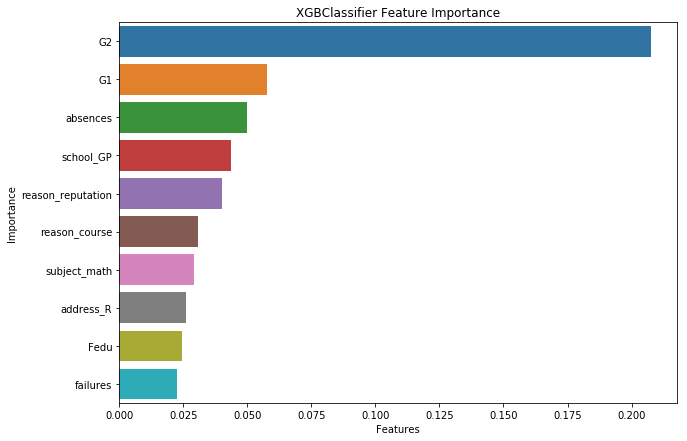

In [364]:
plt.figure(figsize=(10, 7))
sns.barplot(x="imp", y="f", data=df_fpm.sort_values(by='imp', ascending=False)[:10])
plt.title('XGBClassifier Feature Importance');
plt.xlabel('Features'); plt.ylabel('Importance');